In [2]:
import cloudpickle as pickle
import jax
import jax.numpy as jnp
import numpy as onp
import jraph
import matplotlib.pyplot as plt

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
# assemble halo catalogues (just the nodes)

In [4]:
import imnn
import imnn.lfi
from imnn.utils import value_and_jacrev, value_and_jacfwd

import jax
import jax.numpy as jnp

import jraph

import jax_cosmo as jc

import gc

import matplotlib.pyplot as plt

In [5]:
########################### HALO READ SCRIPT #############################

class FoF_catalog:
    """Pylians FoF catalog read script
    see https://pylians3.readthedocs.io/en/master/index.html
    for more information"""
    def __init__(self, basedir, snapnum, long_ids=False, swap=False,
                 SFR=False, read_IDs=True, prefix='/groups_'):

        if long_ids:  format = np.uint64
        else:         format = np.uint32

        exts=('000'+str(snapnum))[-3:]

        #################  READ TAB FILES ################# 
        fnb, skip, Final = 0, 0, False
        dt1 = np.dtype((np.float32,3))
        dt2 = np.dtype((np.float32,6))
        prefix = basedir + prefix + exts + "/group_tab_" + exts + "."
        while not(Final):
            f=open(prefix+str(fnb), 'rb')
            self.Ngroups    = np.fromfile(f, dtype=np.int32,  count=1)[0]
            self.TotNgroups = np.fromfile(f, dtype=np.int32,  count=1)[0]
            self.Nids       = np.fromfile(f, dtype=np.int32,  count=1)[0]
            self.TotNids    = np.fromfile(f, dtype=np.uint64, count=1)[0]
            self.Nfiles     = np.fromfile(f, dtype=np.uint32, count=1)[0]

            TNG, NG = self.TotNgroups, self.Ngroups
            if fnb == 0:
                self.GroupLen    = np.empty(TNG, dtype=np.int32)
                self.GroupOffset = np.empty(TNG, dtype=np.int32)
                self.GroupMass   = np.empty(TNG, dtype=np.float32)
                self.GroupPos    = np.empty(TNG, dtype=dt1)
                self.GroupVel    = np.empty(TNG, dtype=dt1)
                self.GroupTLen   = np.empty(TNG, dtype=dt2)
                self.GroupTMass  = np.empty(TNG, dtype=dt2)
                if SFR:  self.GroupSFR = np.empty(TNG, dtype=np.float32)
                    
            if NG>0:
                locs=slice(skip,skip+NG)
                self.GroupLen[locs]    = np.fromfile(f,dtype=np.int32,count=NG)
                self.GroupOffset[locs] = np.fromfile(f,dtype=np.int32,count=NG)
                self.GroupMass[locs]   = np.fromfile(f,dtype=np.float32,count=NG)
                self.GroupPos[locs]    = np.fromfile(f,dtype=dt1,count=NG)
                self.GroupVel[locs]    = np.fromfile(f,dtype=dt1,count=NG)
                self.GroupTLen[locs]   = np.fromfile(f,dtype=dt2,count=NG)
                self.GroupTMass[locs]  = np.fromfile(f,dtype=dt2,count=NG)
                if SFR:
                    self.GroupSFR[locs]=np.fromfile(f,dtype=np.float32,count=NG)
                skip+=NG

                if swap:
                    self.GroupLen.byteswap(True)
                    self.GroupOffset.byteswap(True)
                    self.GroupMass.byteswap(True)
                    self.GroupPos.byteswap(True)
                    self.GroupVel.byteswap(True)
                    self.GroupTLen.byteswap(True)
                    self.GroupTMass.byteswap(True)
                    if SFR:  self.GroupSFR.byteswap(True)
                        
            curpos = f.tell()
            f.seek(0,os.SEEK_END)
            if curpos != f.tell():
                raise Exception("Warning: finished reading before EOF for tab file",fnb)
            f.close()
            fnb+=1
            if fnb==self.Nfiles: Final=True


        #################  READ IDS FILES ################# 
        if read_IDs:

            fnb,skip=0,0
            Final=False
            while not(Final):
                fname=basedir+"/groups_" + exts +"/group_ids_"+exts +"."+str(fnb)
                f=open(fname,'rb')
                Ngroups     = np.fromfile(f,dtype=np.uint32,count=1)[0]
                TotNgroups  = np.fromfile(f,dtype=np.uint32,count=1)[0]
                Nids        = np.fromfile(f,dtype=np.uint32,count=1)[0]
                TotNids     = np.fromfile(f,dtype=np.uint64,count=1)[0]
                Nfiles      = np.fromfile(f,dtype=np.uint32,count=1)[0]
                Send_offset = np.fromfile(f,dtype=np.uint32,count=1)[0]
                if fnb==0:
                    self.GroupIDs=np.zeros(dtype=format,shape=TotNids)
                if Ngroups>0:
                    if long_ids:
                        IDs=np.fromfile(f,dtype=np.uint64,count=Nids)
                    else:
                        IDs=np.fromfile(f,dtype=np.uint32,count=Nids)
                    if swap:
                        IDs=IDs.byteswap(True)
                    self.GroupIDs[skip:skip+Nids]=IDs[:]
                    skip+=Nids
                curpos = f.tell()
                f.seek(0,os.SEEK_END)
                if curpos != f.tell():
                    raise Exception("Warning: finished reading before EOF for IDs file",fnb)
                f.close()
                fnb+=1
                if fnb==Nfiles: Final=True


# This function is used to write one single file for the FoF instead of having
# many files. This will make faster the reading of the FoF file
def writeFoFCatalog(fc, tabFile, idsFile=None):
    if fc.TotNids > (1<<32)-1: raise Exception('TotNids overflow')

    f = open(tabFile, 'wb')
    np.asarray(fc.TotNgroups).tofile(f)
    np.asarray(fc.TotNgroups).tofile(f)
    np.asarray(fc.TotNids, dtype=np.int32).tofile(f)
    np.asarray(fc.TotNids).tofile(f)
    np.asarray(1, dtype=np.uint32).tofile(f)
    fc.GroupLen.tofile(f)
    fc.GroupOffset.tofile(f)
    fc.GroupMass.tofile(f)
    fc.GroupPos.tofile(f)
    fc.GroupVel.tofile(f)
    fc.GroupTLen.tofile(f)
    fc.GroupTMass.tofile(f)
    if hasattr(fc, 'GroupSFR'):
        fc.GroupSFR.tofile(f)
    f.close()

    if idsFile:
        f = open(idsFile, 'wb')
        np.asarray(fc.TotNgroups).tofile(f)
        np.asarray(fc.TotNgroups).tofile(f)
        np.asarray(fc.TotNids, dtype=np.uint32).tofile(f) 
        np.asarray(fc.TotNids).tofile(f)
        np.asarray(1, dtype=np.uint32).tofile(f)
        np.asarray(0, dtype=np.uint32).tofile(f) 
        fc.GroupIDs.tofile(f)
        f.close()

In [6]:
#@title utils module
import jax.random as jrnd
from functools import partial
import scipy.spatial as SS

import numpy as onp

from functools import partial
import jax
import jax.random as jrnd
import jax.numpy as jnp
import jraph
from scipy.sparse import csgraph
import numpy as np
import os, sys
from struct import unpack

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def get_freqs(shape, L, fourier_b=1.0):
    # set frequencies for jittable fft calculation

    axes = list(range(len(shape)))
    _N = np.array([shape[axis] for axis in axes])

    # Get the box volume if given the real-space box volume
    _L = np.array([L] * len(axes))
    dx = _L / _N
    Lk = 2 * np.pi / (dx * fourier_b)

    Lk = np.array(Lk)
    left_edge = _set_left_edge(None, axes, Lk)

    V = np.product(Lk)
    dk = np.array(Lk) / np.array(_N)

    _myfreq = lambda n,d: fftfreq(n, d=d, b=fourier_b)
    freq = jax.tree_util.tree_map(_myfreq, list(_N), list(dk))
    return freq, axes, left_edge


##### GET NODES FROM FIELD #####
def get_nodes_from_field(key,
                         deltax,
                         pb, 
                         pad_nodes_to=500,
                         nbar=0.000025,
                         randomise_in_cell=True,
                         min_at_zero=True,
                         get_context=True,
                         window=2):
    """
    function for grabbing mock halos from density field
    """

    key,rng = jax.random.split(key)
    
    N = pb.N
    n = (deltax + 1) * pb.dx ** pb.dim * nbar
    n_per_cell = jax.random.poisson(key, n.flatten(), shape=n.flatten().shape)

    mask = (n_per_cell > 0)
    num_nodes = jnp.sum(mask).astype(int)
    
    # make field positive
    deltax += 1.0
    density = deltax.flatten().repeat(
                      n_per_cell.flatten(), axis=0,
                      total_repeat_length=pad_nodes_to
                  )
    # remove dumb repeat padding with zeros
    #TODO: is there a cleaner way to do this ?
    density = jnp.where(density == density[-1], 0., density)
    # Get all source positions
    args = [pb.x] * pb.dim
    X = jnp.meshgrid(*args)
    tracer_positions = jnp.array([x.flatten() for x in X]).T
    tracer_positions = tracer_positions.repeat(
                              n_per_cell.flatten(), axis=0,
                              total_repeat_length=pad_nodes_to)

    if randomise_in_cell:
        noise = (jax.random.uniform(key, shape=(tracer_positions.shape[0], 
                                   pb.dim)) * pb.dx)
        
                                  #.repeat(jnp.sum(n_per_cell), axis=0,
                                  #     total_repeat_length=pad_nodes_to)
                                   
        noise = jnp.where((density == 0.)[:, jnp.newaxis], 0., noise)
                                   
        tracer_positions += noise


    if min_at_zero:
        tracer_positions += pb.boxlength / 2.0

    # pad with zeros
    val = tracer_positions[:, 0][-1]
    tracer_positions = jnp.where((tracer_positions[:, 0] == val)[:, jnp.newaxis], 
                                            0., tracer_positions)

    if get_context:
        
            # Get all source indexes
        args = [jnp.arange(pb.N)] * pb.dim
        X = jnp.meshgrid(*args)
        indexes = jnp.array([x.flatten() for x in X]).T
        indexes = indexes.repeat(
                                 n_per_cell.flatten(), axis=0,
                                 total_repeat_length=pad_nodes_to)

        neighbor_sums = jnp.zeros(indexes.shape[0]) #[]
        idx = jnp.arange(deltax.flatten().shape[0]).reshape(N,N,N)

        w = window
        i_end = N-1
        j_end = i_end
        k_end = i_end

        for l,coord_pair in enumerate(indexes):
            i,j,k = coord_pair

            pad = 2
            w = 3

            neighborhood = jax.lax.dynamic_slice(jnp.pad(deltax, pad_width=pad), 
                                  (i+pad -w//2, j+pad-w//2, k+pad-w//2), (w,w,w))
            neighbor_sums = neighbor_sums.at[l].set(jnp.sum(neighborhood))#.append(jnp.sum(neighborhood))
            
        #neighbor_sums = jnp.array(neighbor_sums)
        neighbor_sums = jnp.where(density == 0., 0., neighbor_sums)

        return tracer_positions, density, neighbor_sums

    else:
        return tracer_positions, density, jnp.zeros(density.shape)

#####################


def get_distances(X):
    nx = X.shape[0]
    return (X[:, None, :] - X[None, :, :])[jnp.tril_indices(nx, k=-1)]


def get_receivers_senders(nx, dists, connect_radius=100):
    '''connect nodes within `connect_radius` units'''
    
    senders,receivers = jnp.tril_indices(nx, k=-1)
    dists = dists[jnp.tril_indices(nx, k=-1)]
    mask = dists < connect_radius
    # pad dummy s,r with n_node
    senders = jnp.where(mask > 0, senders, nx)
    receivers = jnp.where(mask > 0, receivers, nx)
    dists = jnp.where(mask > 0, dists, 0.)
    return senders, receivers, dists

def l2norm_einsum(X, eps=1e-9):
    """calculaute eucl distance with einsum"""
    a_min_b = X[:, None, :] - X[None, :, :]
    norm_sq = jnp.einsum("ijk,ijk->ij", a_min_b, a_min_b)
    return jnp.where(norm_sq < eps, 0, jnp.sqrt(norm_sq))

def get_r2(X):
    """calculate euclidean distance from positional information"""
    nx = X.shape[0]
    #alldists = l2norm(X[:, None, :] - X[None, :, :])
    alldists = l2norm_einsum(X)
    return alldists #[jnp.tril_indices(nx, k=-1)]


##### GET EDGES #####
def edge_builder(pos, r_connect, n_node=None, invert_edges=True,
                     boxsize=1.0001, leafsize=16):
    
    if n_node is not None:
        pos = pos[:n_node]
    
    else:
      n_node = pos.shape[0]

    r_connect = r_connect #simulator_args["connect_radius"] / simulator_args["L"]
    
    print(r_connect)
    
    # kd_tree = SS.KDTree(pos, leafsize=leafsize, boxsize=boxsize)
    # edge_index = onp.array(list((kd_tree.query_pairs(r=r_connect)))).T
    # _senders,_receivers = edge_index

    # mask out halos with distances < connect_radius
    dists = get_r2(pos)
    
    _receivers, _senders, dists = get_receivers_senders(n_node, 
                                                        dists, 
                                                        connect_radius=r_connect)

    diff = pos[_senders] - pos[_receivers]

    # Take into account periodic boundary conditions, correcting the distances
    # for i, pos_i in enumerate(diff):
    #     for j, coord in enumerate(pos_i):
    #         if coord > r_connect:
    #             diff[i,j] -= 1.  # Boxsize normalize to 1
    #         elif -coord > r_connect:
    #             diff[i,j] += 1.  # Boxsize normalize to 1


    num_pairs = dists.shape[0] #edge_index.shape[-1]
    row = _senders
    col = _receivers
    
    # Distance
    dist = dists #jnp.linalg.norm(diff, axis=1)
    
    # Centroid of galaxy catalogue
    centroid = jnp.mean(pos,axis=0)
    
    # Unit vectors of node, neighbor and difference vector
    unitrow = (pos[row]-centroid)/jnp.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
    unitcol = (pos[col]-centroid)/jnp.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
    
    unitdiff = jnp.where((dist.reshape(-1,1) > 0.), diff/dist.reshape(-1,1), 1.)
    
    # Dot products between unit vectors
    #TODO: einsum this
    # cos1 = jnp.array([jnp.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
    # cos2 = jnp.array([jnp.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])
    cos1 = jnp.einsum('ij,ij->i', unitrow, unitcol)
    cos2 = jnp.einsum('ij,ij->i', unitrow, unitdiff)

    # mask out nans
    cos1 = jnp.where(dist == 0., 0., cos1)
    cos2 = jnp.where(dist == 0., 0., cos2)
    
    if invert_edges:
        # flip the distance
        dist = jnp.where((dist > 0.), 1. / (dist*r_connect*100.), dist)
        # sort edges from biggest to smallest
        idx = jnp.argsort(dist)[::-1]
        dist = jnp.sort(dist)[::-1]
    
    else:
        # Normalize distance by linking radius
        dist /= r_connect
        # sort edges from bigges to smallest
        idx = jnp.argsort(dist)[::-1]
        dist = jnp.sort(dist)[::-1]



    cos1 = cos1[idx]
    cos2 = cos2[idx]

    _senders = _senders[idx]
    _receivers = _receivers[idx]

    edge_attr = jnp.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1)], axis=1)
    
    return edge_attr, jnp.array(_senders), jnp.array(_receivers)


##### GET CATALOG BUILDER #####

def halo_catalog_builder(key, θ, deltax, lnpb, simulator_args):
    #A,B = θ
    
    pad_nodes_to = simulator_args['pad_nodes_to']
    pad_edges_to = simulator_args['pad_edges_to']
    nbar = simulator_args["nbar"] # 0.000025
    dim = simulator_args['dim']
    get_context = simulator_args["get_context"]
    window = simulator_args["window"]

    key,rng = jax.random.split(key)
    
    x,masses,neighbor_density = get_nodes_from_field(
                     key,
                     deltax,
                     lnpb, 
                     randomise_in_cell=True,
                     get_context=get_context,
                     pad_nodes_to=pad_nodes_to,
                     nbar=simulator_args["nbar"])
    
    # set positions to size-1 box:
    x /= simulator_args["L"]
    
    
    
    # nodes for graphs
    #node_attr = jnp.concatenate([masses.reshape(-1,1), neighbor_density.reshape(-1,1)], axis=-1)
    
    # full catalog (mass, context, positions)
    catalog = jnp.concatenate([masses.reshape(-1,1), neighbor_density.reshape(-1,1), x], axis=-1)
    
    return catalog

##### GET GRAPH PADDING #####

def padded_graph_builder(catalog, θ, simulator_args, r_connect=None, n_node=None):
    
    # first get all nonzero nodes (if any)
    #mask = catalog[:, 0] != 0.
    #catalog = catalog[mask]

    catalog = jnp.where((catalog[:, 0] > 0.)[:, jnp.newaxis], catalog, 0.)
    
    pad_nodes_to = simulator_args['pad_nodes_to']
    pad_edges_to = simulator_args['pad_edges_to']
    nbar = simulator_args["nbar"] # 0.000025
    dim = simulator_args['dim']
    get_context = simulator_args["get_context"]
    window = simulator_args["window"]
    include_pos = simulator_args["include_pos"]
    node_features = simulator_args["node_features"]

    if r_connect is None:
        r_connect = simulator_args["connect_radius"] / simulator_args["L"]
        
    else:
        r_connect /= simulator_args["L"]

    # get empty arrays
    
    if include_pos:
      nodes = jnp.zeros((pad_nodes_to, node_features))
      edges = jnp.zeros((pad_edges_to, 1)) # dist

    else:
      nodes = jnp.zeros((pad_nodes_to, 8)) # density, neighborhood info
      edges = jnp.zeros((pad_edges_to, 3)) # dist, angle, angle
    
    senders = (jnp.ones((pad_edges_to), dtype=int)*pad_nodes_to).astype(int)
    receivers = (jnp.ones((pad_edges_to), dtype=int)*pad_nodes_to).astype(int)
    
    # unpack node attributes from catalog
    pos = catalog[:, 4:]
    
    if include_pos:
      node_attr = catalog[:, :]

    else:
      node_attr = catalog[:, :2]
      
    n_node = jnp.sum(node_attr[:, 0] > 0.)
    
    # GET EDGE INFORMATION
    edge_attr, _s, _r = edge_builder(jnp.array(pos), r_connect=r_connect,
                                     invert_edges=simulator_args["invert_edges"],
                                     boxsize=1.0001)
    
    if include_pos:
      edge_attr = edge_attr[:, :1]
    
    n_edge = jnp.sum(edge_attr[:, 0] > 0.)
    
    # fill in jax arrays
    
    # edge information
    edges = edges.at[:pad_edges_to, :].set(edge_attr[:pad_edges_to, :])
    senders = senders.at[:pad_edges_to].set(_s[:pad_edges_to])
    receivers = receivers.at[:pad_edges_to].set(_r[:pad_edges_to])

    # add in node information
    nodes = nodes.at[:pad_nodes_to, :].set(node_attr[:pad_nodes_to])

    if simulator_args["squeeze"]:

        graph = jraph.GraphsTuple(nodes=jnp.squeeze(nodes), edges=jnp.squeeze(edges),
                              senders=jnp.squeeze(senders), receivers=jnp.squeeze(receivers),
                              n_node=jnp.array([n_node]), n_edge=jnp.array([n_edge]), globals=jnp.array([θ])
                              )
        return graph

    else:
        graph = jraph.GraphsTuple(nodes=nodes, edges=edges,
                                senders=senders, receivers=receivers,
                                n_node=jnp.array([n_node]), n_edge=jnp.array([n_edge]), globals=jnp.array([θ])
                                )
        return graph
    
    
##### WRAPPER FOR GETTING A GRAPH DIRECTLY FROM DENSITY FIELD #####

def graphs_from_density_field(key, θ, deltax, lnpb, simulator_args):
    """assemble a single, batchable graph from a density field"""
    
    catalog = halo_catalog_builder(key, θ_fid, deltax, lnpb, simulator_args=simulator_args)
    graph = padded_graph_builder(catalog, θ_fid, simulator_args=simulator_args)
    
    return graph


####################### VISUALIZE GRAPH #######################

def plot_graph(graph,
               pos=None,
               ax=None,
               plot_masses=False):
    """visualize jraph graph using Networkx"""
    
    
    mask = onp.squeeze(graph.edges[:, 0]) > 0.
    
    send_receive = [(int(graph.senders[mask][l]), int(graph.receivers[mask][l])) \
                        for l in range(len(graph.receivers[mask]))]


    #if pos is not None:
        #n_node = pos.shape[0] - 1
    #else:
    n_node = onp.squeeze(graph.n_node[0])
    
    G = nx.Graph()
    G.add_nodes_from(list(np.arange(n_node)))
    G.add_edges_from(send_receive)

    if plot_masses:
    
        if pos is None:
            pos = graph.nodes[:, 1:4] #X 
        else:
            pos = pos
      
        masses = graph.nodes[:, 0]

    else:
        if pos is None:
            pos = graph.nodes[:, 1:4]
        else:
            pos = pos
        
        masses = 'k'
    
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(7,4))
    
    if ax is None:
        ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    sc = ax.scatter(*node_xyz.T, s=25, ec='w', c=masses, cmap='gist_gray')


    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray", lw=0.8)


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel(r"$x$", fontsize=15)
        ax.set_ylabel(r"$y$", fontsize=15)
        ax.set_zlabel(r"$z$", fontsize=15)


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')


    ax.view_init(azim=15, elev=20)
    _format_axes(ax)  
    plt.show()
    
    return ax

# do catalog assembly for quijote sims

ORDER OF FEATURES: mass, velx3, posx3

In [65]:
### ASSEMBLY PARAMETERS
mass_cut = 1.85e14
snapnum = 2 # for z=1
N=512 

shape = (N,N,N)


simulator_args = dict(
          N=N,
          L=1.0,
          shape=shape,
          dim=len(shape),
          vol_norm=True,           # whether to normalise P(k) by volume
          L_scale=False,            # scale P(k) by length scale
          connect_radius=0.5,
          pad_nodes_to=2000,
          pad_edges_to=2000, # 4000
          include_pos=True,
          invert_edges=False,
          squeeze=False,
          get_context=True,
          boxsize=None, # or 1.0001
          return_cat=False,
          node_features=7,
)


In [66]:
def load_single_sim(folder_name, 
             sim_num,
             mass_cut=mass_cut,
             snapnum=snapnum):
    # input files
    snapdir = folder_name + '%d/'%(sim_num) #folder hosting the catalogue
    snapnum = snapnum    #vredshift

    # determine the redshift of the catalogue
    z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
    redshift = z_dict[snapnum]

    # read the halo catalogue
    FoF = FoF_catalog(snapdir, snapnum, long_ids=False,
                              swap=False, SFR=False, read_IDs=False)

    # get the properties of the halos
    pos_h = FoF.GroupPos/1e3            # Halo positions in Mpc/h
    mass  = FoF.GroupMass*1e10          # Halo masses in Msun/h
    vel_h = FoF.GroupVel*(1.0+redshift) # Halo peculiar velocities in km/s
    Npart = FoF.GroupLen                # Number of CDM particles in the halo
    
    mass_mask = (mass > mass_cut)
    
    return jnp.hstack([mass[mass_mask].reshape(-1,1)/mass_cut, vel_h[mass_mask]/1000., pos_h[mass_mask]/1000.])

In [67]:
maindir = '/data80/makinen/quijote/Halos/'

In [68]:
np = onp
catalog = load_single_sim(maindir + "Om_m/NCV_0_", 45)

In [69]:
catalog.shape

(1102, 7)

In [71]:
np.max(catalog[:, 0]*mass_cut)

DeviceArray(9.8752036e+14, dtype=float32)

In [72]:
def padded_catalog(catalog, simulator_args=simulator_args):
    pad_nodes_to = simulator_args['pad_nodes_to']
    
    nodes = jnp.zeros((pad_nodes_to, 7))
    nodes = nodes.at[:catalog.shape[0], :].set(catalog[:pad_nodes_to])

    return nodes, catalog.shape[0]

In [73]:
from tqdm import tqdm

In [ ]:
catalogs = []
n_nodes = []
for i in tqdm(range(250)):
    catalog = load_single_sim(maindir + "LC_m/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append(n_node)
    
catalogs = jnp.concatenate(catalogs, axis=0)
n_nodes = jnp.array([n_nodes])

In [30]:
θ_fid = jnp.array([0.3175, 0.834, 0.0])

In [31]:
catalog = jnp.squeeze(catalogs[4])

graph = padded_graph_builder(catalog, θ_fid, simulator_args,\
                                  r_connect=0.15)
    

0.15


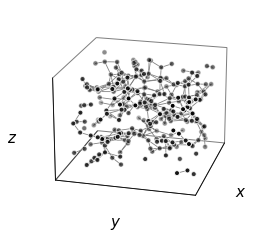

In [32]:
np = onp
ax = plot_graph(graph, catalog[:, 4:])

# build imnn datasets

start with local non-gaussianity

In [37]:
# n_s = 500
# n_d = 250

# n_params = 3
# n_summaries = n_params

# np = jnp
# θ_fid = jnp.array([0.3175, 0.834, 0.0])
# δθ = 2*jnp.array([0.01, 0.015, 100])

# θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), np.diag(δθ) / 2.)).reshape((-1, n_params))

In [74]:
n_s = 500
n_d = 250

n_params = 2
n_summaries = n_params

np = jnp
θ_fid = jnp.array([0.0, 0.0])
δθ = 2*jnp.array([100, 100])

θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), np.diag(δθ) / 2.)).reshape((-1, n_params))

In [75]:
θ_der

DeviceArray([[-100.,    0.],
             [   0., -100.],
             [ 100.,    0.],
             [   0.,  100.]], dtype=float32)

In [76]:
from tqdm import tqdm

In [ ]:
np = onp

# # fiducial
# catalogs = []
# n_nodes = []
# for i in range(n_s):
#     catalog = load_single_sim(maindir + "fiducial/", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
# fid = jraph.GraphsTuple(
#                         nodes=jnp.concatenate(catalogs, axis=0),
#                         n_node=jnp.array([n_nodes]),
#                         edges=None,
#                         n_edge=jnp.array([0.]),
#                         senders=None,
#                         receivers=None,
#                         globals=jnp.tile(θ_fid, (n_s, 1))
#                     )


# # validation fiducial
# catalogs = []
# n_nodes = []
# for i in np.arange(n_s, n_s*2):
#     catalog = load_single_sim(maindir + "fiducial/", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
# val_fid = jraph.GraphsTuple(
#                         nodes=jnp.concatenate(catalogs, axis=0),
#                         n_node=jnp.array([n_nodes]),
#                         edges=None,
#                         n_edge=jnp.array([0.]),
#                         senders=None,
#                         receivers=None,
#                         globals=jnp.tile(θ_fid, (n_s, 1))
#                     )


# # derivative
# catalogs = []
# n_nodes = []
# for i in tqdm(range(n_d)):
#     catalog = load_single_sim(maindir + "Om_m/NCV_0_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
#     catalog = load_single_sim(maindir + "s8_m/NCV_0_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
#     catalog = load_single_sim(maindir + "Om_p/NCV_0_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
#     catalog = load_single_sim(maindir + "s8_p/NCV_0_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
# derv = jraph.GraphsTuple(
#                         nodes=jnp.concatenate(catalogs, axis=0),
#                         n_node=jnp.array([n_nodes]),
#                         edges=None,
#                         n_edge=jnp.array([0.]),
#                         senders=None,
#                         receivers=None,
#                         globals=jnp.tile(θ_der, (n_d, 1))
#                     )


# # validation derivative
# catalogs = []
# n_nodes = []
# for i in tqdm(range(n_d)):
#     catalog = load_single_sim(maindir + "Om_m/NCV_1_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
    
#     catalog = load_single_sim(maindir + "s8_m/NCV_1_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
#     catalog = load_single_sim(maindir + "Om_p/NCV_1_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
#     catalog = load_single_sim(maindir + "s8_p/NCV_1_", i)
#     catalog,n_node = padded_catalog(jnp.squeeze(catalog))
#     catalogs.append(jnp.expand_dims(catalog, 0))
#     n_nodes.append([n_node])
    
    
    
# val_derv = jraph.GraphsTuple(
#                         nodes=jnp.concatenate(catalogs, axis=0),
#                         n_node=jnp.array([n_nodes]),
#                         edges=None,
#                         n_edge=jnp.array([0.]),
#                         senders=None,
#                         receivers=None,
#                         globals=jnp.tile(θ_der, (n_d, 1))
#                             )

In [77]:
np = onp

# fiducial
catalogs = []
n_nodes = []
for i in tqdm(range(n_s)):
    catalog = load_single_sim(maindir + "fiducial/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
fid = jraph.GraphsTuple(
                        nodes=jnp.concatenate(catalogs, axis=0),
                        n_node=jnp.array([n_nodes]),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.tile(θ_fid, (n_s, 1))
                    )


# validation fiducial
catalogs = []
n_nodes = []
for i in tqdm(np.arange(n_s, n_s*2)):
    catalog = load_single_sim(maindir + "fiducial/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
val_fid = jraph.GraphsTuple(
                        nodes=jnp.concatenate(catalogs, axis=0),
                        n_node=jnp.array([n_nodes]),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.tile(θ_fid, (n_s, 1))
                    )


# derivative
catalogs = []
n_nodes = []

index = np.arange(250)

for i in tqdm(index):
    
    catalog = load_single_sim(maindir + "LC_m/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    
    catalog = load_single_sim(maindir + "EQ_m/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    catalog = load_single_sim(maindir + "LC_p/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    catalog = load_single_sim(maindir + "EQ_p/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
derv = jraph.GraphsTuple(
                        nodes=jnp.concatenate(catalogs, axis=0),
                        n_node=jnp.array([n_nodes]),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.tile(θ_der, (n_d, 1))
                    )


# validation derivative
catalogs = []
n_nodes = []

val_index = np.arange(250, 500)

for i in tqdm(val_index):
    catalog = load_single_sim(maindir + "LC_m/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    
    catalog = load_single_sim(maindir + "EQ_m/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    catalog = load_single_sim(maindir + "LC_p/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    catalog = load_single_sim(maindir + "EQ_p/", i)
    catalog,n_node = padded_catalog(jnp.squeeze(catalog))
    catalogs.append(jnp.expand_dims(catalog, 0))
    n_nodes.append([n_node])
    
    
    
val_derv = jraph.GraphsTuple(
                        nodes=jnp.concatenate(catalogs, axis=0),
                        n_node=jnp.array([n_nodes]),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.tile(θ_der, (n_d, 1))
                            )

100%|██████████| 250/250 [03:48<00:00,  1.09it/s]


In [78]:
from pathlib import Path
#Path("/my/directory").mkdir(parents=True, exist_ok=True)


def save_graph_attributes(halograph, folder, name):
    # make folder for each graph
    fname = folder + name
    print("saving to", fname)
    Path(fname).mkdir(parents=True, exist_ok=True)
    
    np.save(fname + "nodes", halograph.nodes)
    np.save(fname + "globals", halograph.globals)
    np.save(fname + "n_node", halograph.n_node)
    
def load_graph_attributes(folder, name):
    
    # make folder for each graph
    fname = folder + name
    print("loading from", fname)
    Path(fname).mkdir(parents=True, exist_ok=True)
    
    nodes = np.load(fname + "nodes.npy")
    globalz = np.load(fname + "globals.npy")
    n_node = np.load(fname + "n_node.npy")
    
    return jraph.GraphsTuple(
                        nodes=jnp.array(nodes),
                        n_node=jnp.array(n_node),
                        edges=None,
                        n_edge=jnp.array([0.]),
                        senders=None,
                        receivers=None,
                        globals=jnp.array(globalz)
                            )
    

In [79]:
outdir = '/data80/makinen/quijote/graphs/png/z_1/'

# save all of the graph attributes
save_graph_attributes(fid, folder=outdir, name='lc_eq_fid/')

save_graph_attributes(val_fid, folder=outdir, name='lc_eq_val_fid/')

save_graph_attributes(val_derv, folder=outdir, name='lc_eq_val_derv/')
#new_val_derv = load_graph_attributes(folder=outdir, name='val_derv/')

save_graph_attributes(derv, folder=outdir, name='lc_eq_derv/')
#new_val_derv = load_graph_attributes(folder=outdir, name='val_derv/')


saving to /data80/makinen/quijote/graphs/png/z_1/lc_eq_fid/
saving to /data80/makinen/quijote/graphs/png/z_1/lc_eq_val_fid/
saving to /data80/makinen/quijote/graphs/png/z_1/lc_eq_val_derv/
saving to /data80/makinen/quijote/graphs/png/z_1/lc_eq_derv/


In [20]:
outdir = '/data80/makinen/quijote/graphs/png/'


derv = load_graph_attributes(folder=outdir, name='lc_eq_derv/')
val_derv = load_graph_attributes(folder=outdir, name='lc_eq_val_derv/')

loading from /data80/makinen/quijote/graphs/png/lc_eq_derv/
loading from /data80/makinen/quijote/graphs/png/lc_eq_val_derv/


In [ ]:
outdir = '/data80/makinen/quijote/graphs/'

#save_obj(fid, outdir + 'fid_mcut_1.1')
#save_obj(val_fid, outdir + 'val_fid_mcut_1.1')
save_obj(derv, outdir + 'derv_mcut_1.1')
save_obj(val_derv, outdir + 'val_derv_mcut_1.1')

In [ ]:
derv = load